## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Салихова Кария Илшатовна

In [1]:
import numpy as np
from sklearn.datasets import fetch_mldata
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from IPython.display import clear_output
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [5]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [6]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

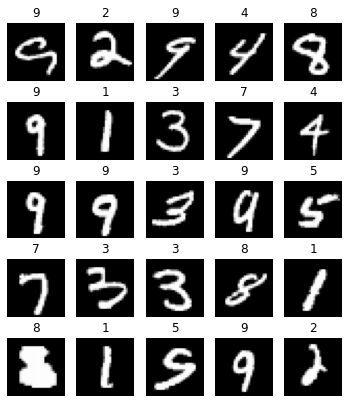

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [6]:
def init_layer(layer, mean=0, std=0.1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=mean, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    print('forward', std)

def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    print('backward', std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [7]:
def make_linear(in_dim, out_dim, init_func):
    layer = nn.Linear(in_dim, out_dim)
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_func(layer)
    
    return layer

In [8]:
net = []
net.append(make_linear(28*28, 500, init_layer))
net.append(nn.Tanh())
for i in range(10):
    net.append(make_linear(500, 500, init_layer))
    net.append(nn.Tanh())
net.append(make_linear(500, 10, init_layer))
net.append(nn.Tanh())
net = nn.Sequential(*net)
net

Sequential(
  (0): Linear(in_features=784, out_features=500, bias=True)
  (1): Tanh()
  (2): Linear(in_features=500, out_features=500, bias=True)
  (3): Tanh()
  (4): Linear(in_features=500, out_features=500, bias=True)
  (5): Tanh()
  (6): Linear(in_features=500, out_features=500, bias=True)
  (7): Tanh()
  (8): Linear(in_features=500, out_features=500, bias=True)
  (9): Tanh()
  (10): Linear(in_features=500, out_features=500, bias=True)
  (11): Tanh()
  (12): Linear(in_features=500, out_features=500, bias=True)
  (13): Tanh()
  (14): Linear(in_features=500, out_features=500, bias=True)
  (15): Tanh()
  (16): Linear(in_features=500, out_features=500, bias=True)
  (17): Tanh()
  (18): Linear(in_features=500, out_features=500, bias=True)
  (19): Tanh()
  (20): Linear(in_features=500, out_features=500, bias=True)
  (21): Tanh()
  (22): Linear(in_features=500, out_features=10, bias=True)
  (23): Tanh()
)

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [9]:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = net(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

forward 1.0007532835006714
forward 0.8488026261329651
forward 0.7845470309257507
forward 0.7721006870269775
forward 0.7656279802322388
forward 0.7640690207481384
forward 0.7645633220672607
forward 0.7629857659339905
forward 0.7646125555038452
forward 0.7677324414253235
forward 0.7666043043136597
forward 0.7637938857078552
backward 0.018431732431054115
backward 0.006054173223674297
backward 0.005852438043802977
backward 0.006239973474293947
backward 0.007159508764743805
backward 0.00812680646777153
backward 0.00966994371265173
backward 0.010880525223910809
backward 0.013616765849292278
backward 0.014808875508606434
backward 0.01735946163535118
backward 0.01776329055428505


<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [10]:
def dumb_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=1)

def xavier_init(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    d = 2 / (weight.size()[0] + weight.size()[1])
    weight.normal_(mean=0, std=np.sqrt(d))
    
def xavier_init_uni(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    r = np.sqrt(6 / (weight.size()[0] + weight.size()[1]))
    weight.uniform_(-r, r)
    
def init_he(layer):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    
    d = 2 / weight.size()[1]
    weight.normal_(mean=0, std=np.sqrt(d))

In [12]:
print("Xavier, Tanh:")
net = []
net.append(make_linear(28*28, 500, xavier_init_uni))
net.append(nn.Tanh())
for i in range(10):
    net.append(make_linear(500, 500, xavier_init_uni))
    net.append(nn.Tanh())
net.append(make_linear(500, 10, xavier_init_uni))
net.append(nn.Tanh())
net = nn.Sequential(*net)

#пример:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = net(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

Xavier, Tanh:
forward 1.0007532835006714
forward 0.6506139039993286
forward 0.4954039752483368
forward 0.4138047695159912
forward 0.363707035779953
forward 0.3288120925426483
forward 0.29933205246925354
forward 0.2776794731616974
forward 0.25538936257362366
forward 0.23906400799751282
forward 0.22648340463638306
forward 0.21346139907836914
backward 0.030222665518522263
backward 0.017798885703086853
backward 0.016994141042232513
backward 0.017034199088811874
backward 0.016562853008508682
backward 0.01513589546084404
backward 0.013511267490684986
backward 0.011886748485267162
backward 0.010937237180769444
backward 0.009246980771422386
backward 0.007068453822284937
backward 0.0043094344437122345


In [13]:
print("He, ReLU: ")
net = []
net.append(make_linear(28*28, 500, init_he))
net.append(nn.ReLU())
for i in range(10):
    net.append(make_linear(500, 500, init_he))
    net.append(nn.ReLU())
net.append(make_linear(500, 10, init_he))
net.append(nn.ReLU())
net = nn.Sequential(*net)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = net(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

He, ReLU: 
forward 1.0007532835006714
forward 0.8576433658599854
forward 0.8809902667999268
forward 0.8462381362915039
forward 0.8161015510559082
forward 0.7972633242607117
forward 0.7679492235183716
forward 0.7538515329360962
forward 0.7823071479797363
forward 0.7447047829627991
forward 0.7511163353919983
forward 0.7739951610565186
backward 0.04423421993851662
backward 0.008926269598305225
backward 0.00854965765029192
backward 0.008088283240795135
backward 0.007216264493763447
backward 0.006667423993349075
backward 0.006288082338869572
backward 0.006760058458894491
backward 0.005933498032391071
backward 0.005631417501717806
backward 0.0053434818983078
backward 0.004778954666107893


In [14]:
print("He, Tanh: ")
net = []
net.append(make_linear(28*28, 500, init_he))
net.append(nn.Tanh())
for i in range(10):
    net.append(make_linear(500, 500, init_he))
    net.append(nn.Tanh())
net.append(make_linear(500, 10, init_he))
net.append(nn.Tanh())
net = nn.Sequential(*net)

n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
activations = net(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(layer.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

He, Tanh: 
forward 1.0007532835006714
forward 0.712689220905304
forward 0.6304568648338318
forward 0.5889778137207031
forward 0.5729942917823792
forward 0.5655695796012878
forward 0.5623782277107239
forward 0.5574598908424377
forward 0.5563308000564575
forward 0.5585323572158813
forward 0.5587337613105774
forward 0.5570178031921387
backward 0.026324238628149033
backward 0.01029734592884779
backward 0.010254588909447193
backward 0.009940597228705883
backward 0.009521766565740108
backward 0.009775524958968163
backward 0.009129072539508343
backward 0.009409578517079353
backward 0.009181411936879158
backward 0.00910596176981926
backward 0.008087617345154285
backward 0.006680709775537252


<i> 1.4 Сделайте выводы по первой части </i>

<i>He</i> в комбинации с <i>ReLU</i> работает лучше, чем <i>He</i> с <i>Tanh</i> или <i>Xavier</i> с <i>Tanh</i> - градиенты затухают с меньшей скоростью, чем в других случаях.

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [15]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5, mean=0, std=0.01):
        super(DropConnect, self).__init__()
        w = torch.Tensor(input_dim, output_dim).normal_(mean=mean, std=std)
        b = torch.Tensor(1, output_dim).zero_()
        self.weight = nn.Parameter(w)
        self.bias = nn.Parameter(b)
        self.p = p

    def forward(self, x):
        if self.training:
            mask = torch.zeros_like(self.weight).bernoulli_(self.p)
        else:
            mask = torch.ones_like(self.weight) * self.p
        mask = mask.data
        output = torch.mm(x, self.weight*mask)+self.bias
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Dropout между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [3]:
def train(network, epochs, learning_rate):
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.size(0), -1)
                network.zero_grad()
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                loss_batch.backward()
                optimizer.step()
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []    
            for X, y in test_loader:
                X = X.view(X.size(0), -1)
                prediction = network(X)
                loss_batch = loss(prediction, y)
                losses.append(loss_batch.item())
                accuracies.append((np.argmax(prediction.data.numpy(), 1)==y.data.numpy()).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            print('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                        train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs, label='Train')
            plt.plot(test_loss_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs, label='Train')
            plt.plot(test_accuracy_epochs, label='Test')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Accuracy', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

Epoch 4... (Train/Test) NLL: 0.607/0.630	Accuracy: 0.846/0.844


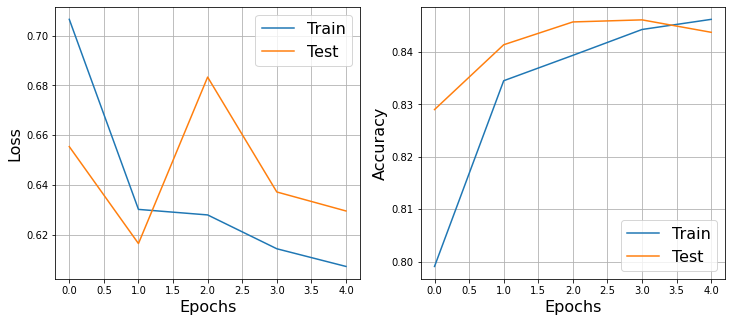

In [17]:
net1 = nn.Sequential(nn.Linear(784, 200),
                     nn.Dropout(),
                     nn.ReLU(),
                     nn.Linear(200, 200),
                     nn.Dropout(),
                     nn.ReLU(),
                     nn.Linear(200, 10),
                     nn.LogSoftmax())

train(net1, 5, 0.01)

Epoch 4... (Train/Test) NLL: 0.261/0.299	Accuracy: 0.931/0.926


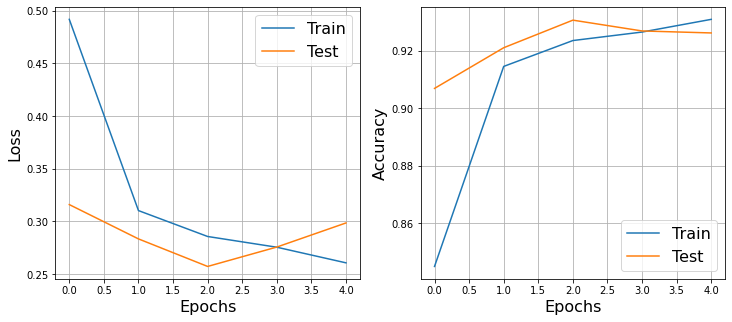

In [18]:
net2 = nn.Sequential(DropConnect(784, 200, 0.5),
                     nn.ReLU(),
                     DropConnect(200, 200, 0.5),
                     nn.ReLU(),
                     DropConnect(200, 10, 0.5),
                     nn.LogSoftmax())

train(net2, 5, 0.01)

<i> 2.3 Сделайте выводы по третьей части. Отобразите кривые обучения на одном графике </i>

In [19]:
def all_train(net1, net2, epochs, learning_rate):
    loss = nn.NLLLoss()
    optimizer1 = torch.optim.Adam(net1.parameters(), lr=learning_rate)
    optimizer2 = torch.optim.Adam(net2.parameters(), lr=learning_rate)
    train_loss_epochs1 = []
    train_accuracy_epochs1 = []
    train_loss_epochs2 = []
    train_accuracy_epochs2 = []
    try:
        for epoch in range(epochs):
            losses1 = []
            accuracies1 = []
            losses2 = []
            accuracies2 = []
            for X, y in train_loader:
                X = X.view(X.size(0), -1)
                net1.zero_grad()
                prediction1 = net1(X)
                loss_batch1 = loss(prediction1, y)
                losses1.append(loss_batch1.item())
                loss_batch1.backward()
                optimizer1.step()
                accuracies1.append((np.argmax(prediction1.data.numpy(), 1)==y.data.numpy()).mean())
                
                net2.zero_grad()
                prediction2 = net2(X)
                loss_batch2 = loss(prediction2, y)
                losses2.append(loss_batch2.item())
                loss_batch2.backward()
                optimizer2.step()
                accuracies2.append((np.argmax(prediction2.data.numpy(), 1)==y.data.numpy()).mean())
            train_loss_epochs1.append(np.mean(losses1))
            train_accuracy_epochs1.append(np.mean(accuracies1))
            train_loss_epochs2.append(np.mean(losses2))
            train_accuracy_epochs2.append(np.mean(accuracies2))
            clear_output(True)
            print('\rEpoch {0}... (DropOut/DropConnect) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                        epoch, train_loss_epochs1[-1], train_loss_epochs2[-1],
                        train_accuracy_epochs1[-1], train_accuracy_epochs2[-1]))
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.plot(train_loss_epochs1, label='DropOut')
            plt.plot(train_loss_epochs2, label='DropConnect')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.subplot(1, 2, 2)
            plt.plot(train_accuracy_epochs1, label='DropOut')
            plt.plot(train_accuracy_epochs2, label='DropConnect')
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Accuracy', fontsize=16)
            plt.legend(loc=0, fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        pass

Epoch 4... (DropOut/DropConnect) NLL: 0.645/0.265	Accuracy: 0.833/0.932


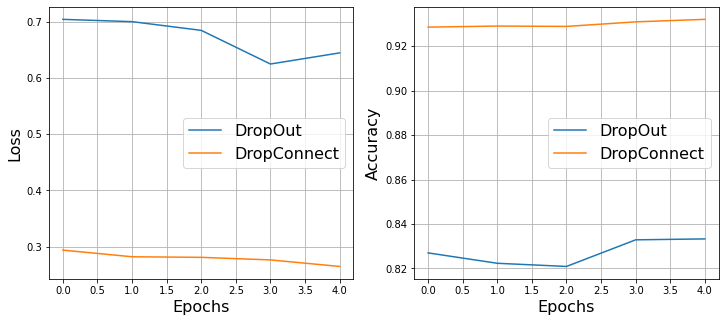

In [20]:
all_train(net1, net2, 5, 0.01)

Видим, что DropConnect в целом показал себя лучше, чем DropOut. Кажется, что убивать нейроны целиком в нашем примере - слишком жестоко - можно заметить, что в процессе обучения у DropOut может увеличиваться Loss и уменьшаться качество, в то время как у DropConnect мы этого не наблюдаем.

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [7]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def __init__(self, features, eps=1e-7):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps
    def forward(self, x):
        mean = x.mean(dim=1).view(-1, 1)
        std = x.std(dim=1).view(-1, 1)
        output = self.alpha * (x - mean) / (std + self.eps) + self.beta
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. 784 -> 200 -> 200 -> 10 с ReLU и Batch normalization между всеми слоями 
2. 784 -> 200 -> 200 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 4... (Train/Test) NLL: 0.042/0.099	Accuracy: 0.986/0.972


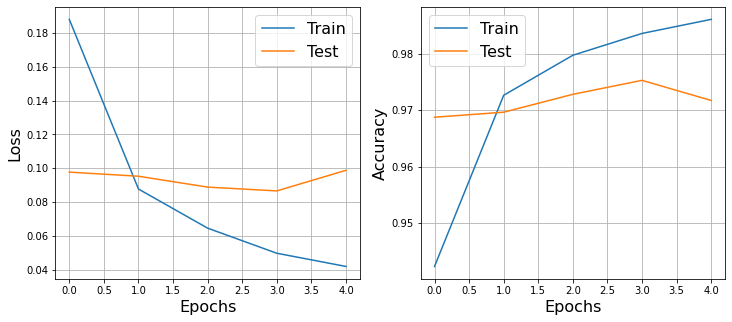

In [8]:
net1 = nn.Sequential(nn.Linear(784, 200),
                     nn.BatchNorm1d(200),
                     nn.ReLU(),
                     nn.Linear(200, 200),
                     nn.BatchNorm1d(200),
                     nn.ReLU(),
                     nn.Linear(200, 10),
                     nn.LogSoftmax())

train(net1, 5, 0.01)

Epoch 4... (Train/Test) NLL: 0.050/0.077	Accuracy: 0.984/0.977


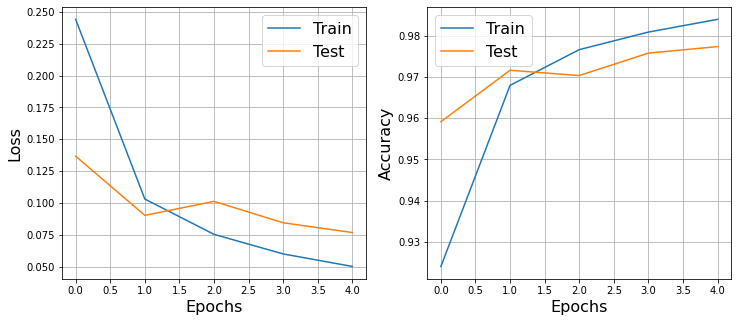

In [10]:
net1 = nn.Sequential(nn.Linear(784, 200),
                     LayerNormalization(200),
                     nn.ReLU(),
                     nn.Linear(200, 200),
                     LayerNormalization(200),
                     nn.ReLU(),
                     nn.Linear(200, 10),
                     nn.LogSoftmax())

train(net1, 5, 0.01)

<i> 3.3 Сделайте выводы по третьей части </i>

Для нашего датасета LayerNormalization показал себя лучше, чем BatchNormalization.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: